In [1]:
# Imports
import pandas as pd
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel, VoigtModel, LinearModel, ConstantModel, SkewedGaussianModel
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statistics import mean, median
from scipy.stats import skewnorm, gamma
from tqdm import tqdm
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import numpy as np
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statistics import mean, median
from tensorflow.keras import models, layers
from tensorflow.keras.layers import BatchNormalization, Activation, Conv1D, Input, Flatten, Dense, Dropout, MaxPool1D
from tensorflow.keras.optimizers import schedules, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
import tensorflow as tf
import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from keras import regularizers, losses, metrics

In [2]:
# Load the dataset
df = pd.read_csv('train_dataset_RAW.csv')
# Parse the dataset
cr = df['Cr']
clean_df=df.T
clean_df.drop(clean_df.tail(8).index, inplace=True)
clean_df.index = clean_df.index.to_series().astype(str).str.replace('X','',regex=True).astype(float)
clean_df.index = clean_df.index.astype(float)

In [16]:
# Model architecture
def buildmodel():
    model = models.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape = (40002 ,1)))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1, activation="linear"))



    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
    return model
    
model = buildmodel()
model.summary()

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 40002, 50)         100       
                                                                 
 dense_96 (Dense)            (None, 40002, 50)         2550      
                                                                 
 dense_97 (Dense)            (None, 40002, 50)         2550      
                                                                 
 dense_98 (Dense)            (None, 40002, 1)          51        
                                                                 
Total params: 5,251
Trainable params: 5,251
Non-trainable params: 0
_________________________________________________________________


In [18]:
#XVD
k_selections = 30
test_sample_size = 7
RMSE_list = np.zeros(k_selections)
for k in tqdm(range(k_selections)):
    # Divide data into training and testing set and reshape
    unique_test_id = random.sample(range(42),test_sample_size)
    test_id = [list(range(i*50,i*50+50)) for i in unique_test_id]
    test_id = [item for sublist in test_id for item in sublist]
    x_train = clean_df.drop(test_id, axis=1).to_numpy()
    y_train = cr.drop(test_id).to_numpy()
    x_test = clean_df.iloc[:,test_id].to_numpy()
    y_test = cr.iloc[test_id].to_numpy()
    x_train = np.swapaxes(x_train, 0, 1)
    x_test = np.swapaxes(x_test, 0, 1)
    # Scale data
    x_scaler_mean = np.mean(x_train)
    x_scaler_std = np.std(x_train)
    X_train = (x_train[:,:, np.newaxis]-x_scaler_mean)/x_scaler_std
    X_test = (x_test[:, :, np.newaxis]-x_scaler_mean)/x_scaler_std
    # Build model
    model = buildmodel()
    # Fit model
    history = model.fit(X_train, y_train, epochs=10, batch_size=10)#, verbose=0)
    # Have model make prediction
    Y_pred_test = model.predict(X_test, verbose=0)
    # Calculate and append RMSE
    RMSE_list[k] = np.sqrt(np.mean(Y_pred_test-y_test)**2)

  0%|                                                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/10
175/175 [==============================] - 65s 368ms/step - loss: 146.1219 - mae: 9.7761
Epoch 2/10
175/175 [==============================] - 65s 374ms/step - loss: 108.2001 - mae: 9.5696
Epoch 3/10
175/175 [==============================] - 66s 377ms/step - loss: 108.1836 - mae: 9.5780
Epoch 4/10
175/175 [==============================] - 66s 379ms/step - loss: 107.6666 - mae: 9.5603
Epoch 5/10
175/175 [==============================] - 67s 382ms/step - loss: 107.7977 - mae: 9.5681
Epoch 6/10
175/175 [==============================] - 71s 406ms/step - loss: 107.9553 - mae: 9.5876
Epoch 7/10
175/175 [==============================] - 72s 414ms/step - loss: 107.7562 - mae: 9.5602
Epoch 8/10
175/175 [==============================] - 72s 409ms/step - loss: 107.6959 - mae: 9.5620
Epoch 9/10
175/175 [==============================] - 72s 412ms/step - loss: 107.8550 - mae: 9.5772
Epoch 10/10
175/175 [==============================] - 73s 414ms/step - loss: 107.4899 - mae: 9.5499

  0%|                                                                                                                           | 0/30 [14:13<?, ?it/s]


MemoryError: Unable to allocate 36.5 GiB for an array with shape (350, 40002, 350) and data type float64

1.528098963810862

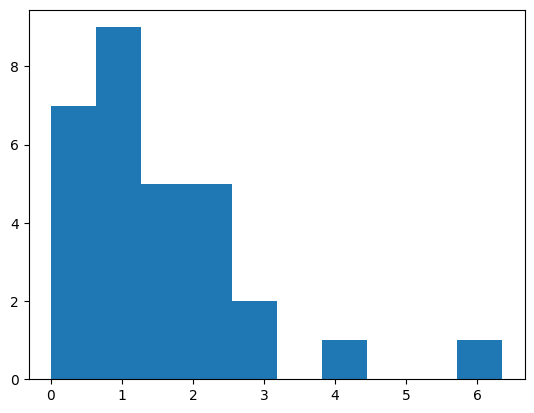

In [12]:
plt.hist(RMSE_list)
np.mean(RMSE_list)